In [1]:
import random

import numpy as np
from ground_truth import test_combination
from algorithm import AlgorithmState, get_next_combination, get_next_combinations_confidence_bounds, update_state
from tqdm import tqdm

triangle_size_bounds = (50, 300)
saturation_bounds = (0.5, 1.0)
get_next_combination_strategy = "rectangles"
iterations = 10
test_combination = test_combination
success_rate_threshold=0.85
total_samples_threshold=5

# set seed for reproducibility
random.seed(0)
np.random.seed(0)


state = AlgorithmState(triangle_size_bounds, saturation_bounds)
combinations = []

if get_next_combination_strategy == "rectangles":
    get_next_combination_strategy = get_next_combination
elif get_next_combination_strategy == "confidence_bounds":
    get_next_combination_strategy = get_next_combinations_confidence_bounds
else:
    raise ValueError("Invalid strategy")

for _ in tqdm(range(iterations), desc="Sampling Iterations"):
    combination, selected_rect = get_next_combination_strategy(state)
    if not combination:
        break

    success = test_combination(
        combination["triangle_size"],
        combination["saturation"],
        bounds=(triangle_size_bounds, saturation_bounds),
    )

    state = update_state(
        state,
        selected_rect,
        combination,
        success,
        success_rate_threshold,
        total_samples_threshold,
    )

    combination["success"] = success
    combinations.append(combination)

Sampling Iterations: 100%|██████████| 10/10 [00:00<00:00, 49991.70it/s]


 - Smoothing Error: 8.591789860364225


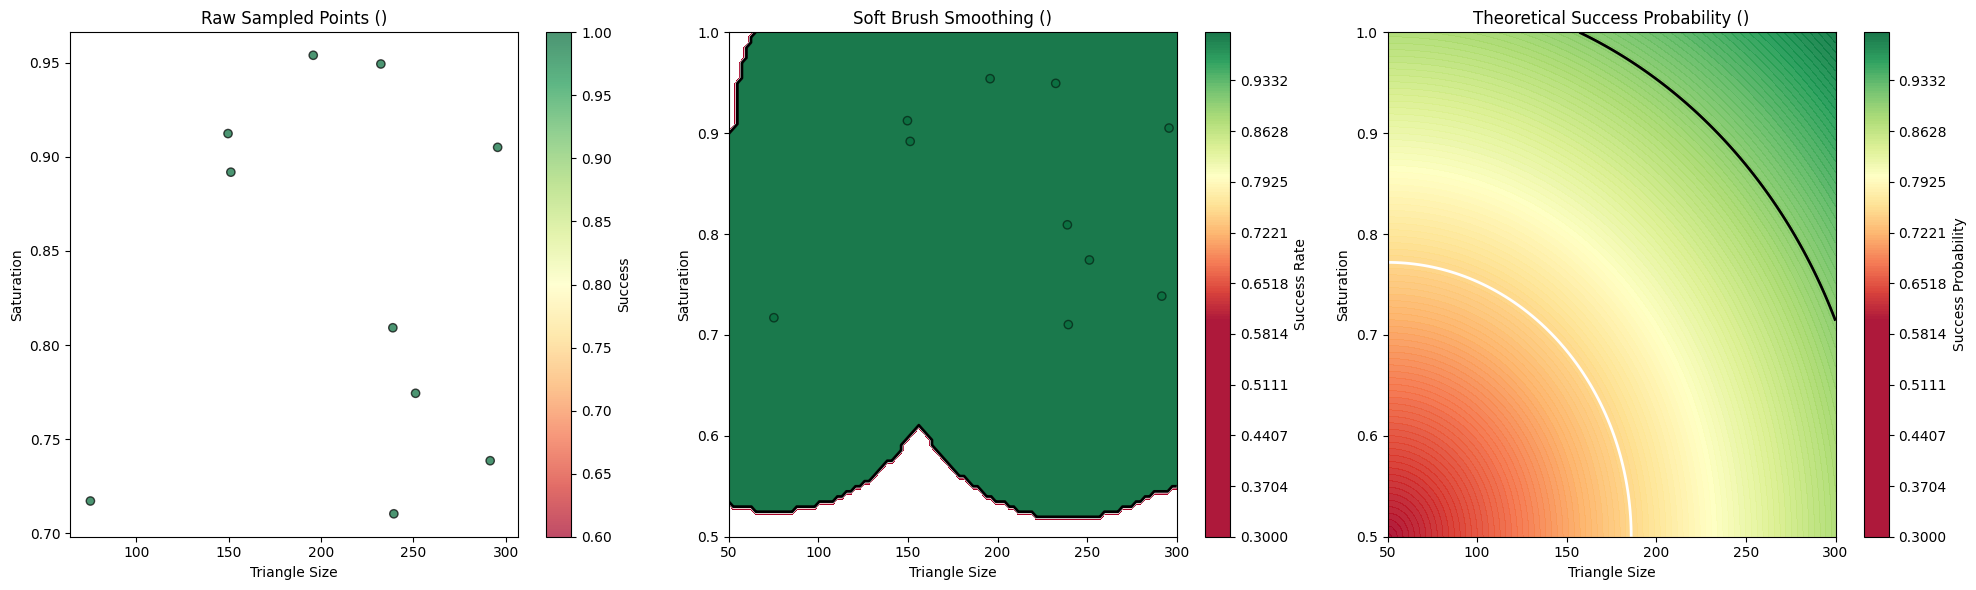

In [2]:
from plotting import create_plots
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

smoothing_params = {
    "inner_radius": 9.8,
    "outer_radius": 96.7,
    "k": 200,
}

_ = create_plots(
    combinations,
    triangle_size_bounds,
    saturation_bounds,
    ax_raw=axs[0],
    ax_smooth=axs[1],
    ax_model=axs[2],
    smoothing_params=smoothing_params,
    smoothing_method="soft_brush",
)

plt.tight_layout()

Text(0.5, 1.0, 'Exponential Decay')

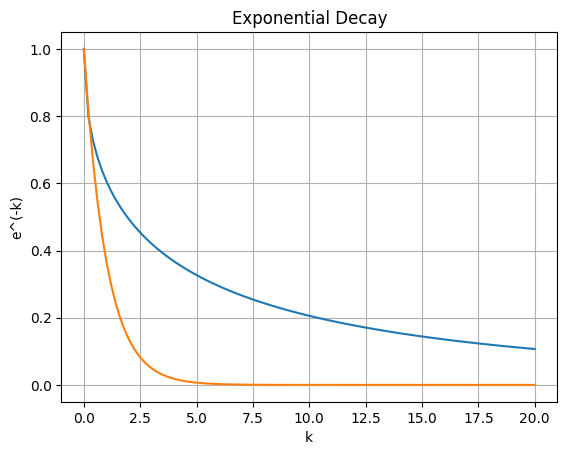

In [3]:
import numpy as np

k = np.linspace(0, 20, 100)
ye = np.exp(-k)
ys = 0.5 * np.sqrt(k)
y = np.exp(-0.5 * np.sqrt(k))

plt.figure()
plt.plot(k, y)
plt.plot(k, ye)
# plt.plot(k, ys)
plt.grid(True)
plt.xlabel('k')
plt.ylabel('e^(-k)')
plt.title('Exponential Decay')

In [4]:
from plotting import get_scaled_radii
import pandas as pd

def compute_sample_density(
    df,
    triangle_size_bounds,
    saturation_bounds,
    params=None
):
    """
    Compute sample density for each point using soft brush approach.
    Returns a grid of density values where higher values indicate more samples in the area.
    
    Args:
        df: DataFrame with 'triangle_size' and 'saturation' columns
        triangle_size_bounds: Tuple of (min, max) for triangle size
        saturation_bounds: Tuple of (min, max) for saturation
        params: Dictionary with optional 'inner_radius' and 'outer_radius'
    
    Returns:
        X, Y: Meshgrid coordinates
        Z_density: Grid of density values
    """
    points = df[["triangle_size", "saturation"]].values
    
    # Get default radii if not provided
    inner_radius, outer_radius = get_scaled_radii((triangle_size_bounds, saturation_bounds))
    if params:
        inner_radius = params.get("inner_radius", inner_radius)
        outer_radius = params.get("outer_radius", outer_radius)

    # Normalize coordinates
    triangle_min, triangle_max = triangle_size_bounds
    saturation_min, saturation_max = saturation_bounds

    points_normalized = np.empty_like(points, dtype=np.float64)
    points_normalized[:, 0] = (points[:, 0] - triangle_min) / (triangle_max - triangle_min)
    points_normalized[:, 1] = (points[:, 1] - saturation_min) / (saturation_max - saturation_min)

    # Create grid
    grid_x = np.linspace(triangle_min, triangle_max, 100)
    grid_y = np.linspace(saturation_min, saturation_max, 100)
    X, Y = np.meshgrid(grid_x, grid_y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])

    # Normalize grid points
    grid_points_normalized = np.empty_like(grid_points, dtype=np.float64)
    grid_points_normalized[:, 0] = (grid_points[:, 0] - triangle_min) / (triangle_max - triangle_min)
    grid_points_normalized[:, 1] = (grid_points[:, 1] - saturation_min) / (saturation_max - saturation_min)

    # Normalize radii
    max_range = max(triangle_max - triangle_min, saturation_max - saturation_min)
    inner_radius_norm = inner_radius / max_range
    outer_radius_norm = outer_radius / max_range

    # Compute squared radii
    inner_radius_sq = inner_radius_norm**2
    outer_radius_sq = outer_radius_norm**2

    # Calculate distances
    from sklearn.metrics import pairwise_distances
    distances_sq = pairwise_distances(grid_points_normalized, points_normalized, metric="sqeuclidean")

    # Calculate weights based on distances
    weights = np.where(
        distances_sq <= inner_radius_sq,
        1.0,
        np.where(
            (distances_sq > inner_radius_sq) & (distances_sq <= outer_radius_sq),
            (outer_radius_norm - np.sqrt(distances_sq)) / (outer_radius_norm - inner_radius_norm),
            0.0,
        ),
    )

    # Sum up weights to get density
    Z_density = np.sum(weights, axis=1)
    Z_density = Z_density.reshape(X.shape)

    # Normalize density to [0, 1] range
    # Z_density = (Z_density - Z_density.min()) / (Z_density.max() - Z_density.min())
    # Z_density = 1 - Z_density

    Z_density = np.exp(-0.5 * np.sqrt(Z_density))

    return X, Y, Z_density

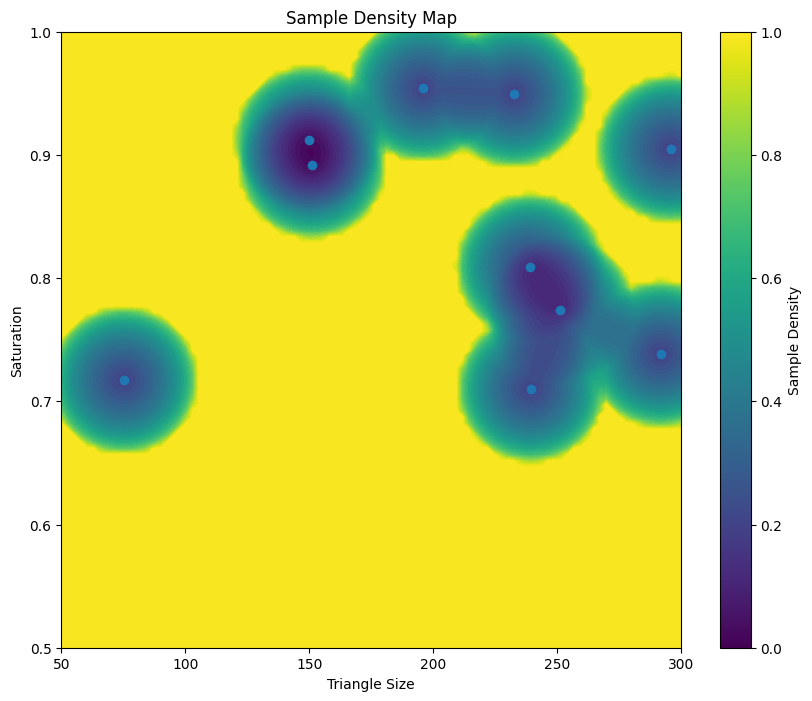

In [5]:
from plotting import compute_soft_brush_smooth

df = pd.DataFrame(combinations)
df["success_float"] = df["success"].astype(float)

params = {
    "inner_radius": 3,
    "outer_radius": 30,
}

# Example usage
X, Y, variance = compute_sample_density(
    df,
    triangle_size_bounds=triangle_size_bounds, 
    saturation_bounds=saturation_bounds,   
    params=params,   
)

X_2, Y_2, mean = compute_soft_brush_smooth(
    df, 
    triangle_size_bounds=triangle_size_bounds,
    saturation_bounds=saturation_bounds,
    params=params,
)

# Visualize the density
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, variance, levels=50, cmap='viridis')
plt.scatter(df['triangle_size'], df['saturation'])
plt.colorbar(label='Sample Density')
plt.xlabel('Triangle Size')
plt.ylabel('Saturation')
plt.title('Sample Density Map')
plt.show()

In [6]:
df.head()

,triangle_size,saturation,success,success_float
0,239.488601,0.710286,True,1.0
1,151.233534,0.891899,True,1.0
2,195.845510,0.954056,True,1.0
3,238.951051,0.809184,True,1.0
4,295.696369,0.905109,True,1.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator

def truncated_gaussian_integral(lower, upper, mu, sigma, phase_threshold):
    """
    Computes the integral over [lower, upper] of the clipped density:
      g(x) = min(f(x), phase_threshold)
    where f(x) is the Gaussian density with mean mu and std sigma.
    
    If phase_threshold >= f(mu) = 1/(sqrt(2*pi)*sigma), no truncation is needed.
    
    Parameters:
      lower, upper : float
          Integration bounds.
      mu : float
          Mean of the Gaussian.
      sigma : float
          Standard deviation of the Gaussian.
      phase_threshold : float
          Maximum allowed density value.
          
    Returns:
      w : float
          The integrated value ∫ₗᵤ min(f(x), phase_threshold) dx.
    """
    # Maximum of the Gaussian is at x=mu:
    fmax = 1/(np.sqrt(2*np.pi)*sigma)
    
    # If no truncation is needed, return the standard integral.
    if phase_threshold >= fmax:
        return norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)
    
    # Otherwise, determine the region around mu where f(x) > phase_threshold.
    # Solve f(x)=phase_threshold:
    # phase_threshold = 1/(sqrt(2*pi)*sigma) * exp(-((x-mu)^2/(2*sigma^2)))
    # => d = sigma * sqrt(-2 * ln(phase_threshold * sqrt(2*pi)*sigma))
    d = sigma * np.sqrt(-2 * np.log(phase_threshold * np.sqrt(2*np.pi)*sigma))
    L_interval = mu - d  # left boundary where f(x)==phase_threshold
    R_interval = mu + d  # right boundary
    
    # Determine the intersection I = [I_low, I_high] of [lower, upper] and [L_interval, R_interval].
    I_low = max(lower, L_interval)
    I_high = min(upper, R_interval)
    intersection_length = max(0, I_high - I_low)
    
    # Full integral over [lower, upper] (without clipping)
    full_int = norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma)
    
    # Integral of f(x) over the intersection region (if any)
    if intersection_length > 0:
        inter_int = norm.cdf(I_high, loc=mu, scale=sigma) - norm.cdf(I_low, loc=mu, scale=sigma)
    else:
        inter_int = 0.0
    
    # Over the intersection region, we cut f(x) to phase_threshold.
    # Thus the contribution is: phase_threshold * (intersection length)
    # Outside that, we use the original f(x).
    w = phase_threshold * intersection_length + (full_int - inter_int)
    return w

def sample_point_from_grid(mean_grid, var_grid, 
                           corridor=(0.64, 0.85),
                           x_bounds=(0, 1), y_bounds=(0, 1),
                           phase_threshold=2):
    """
    Samples a continuous (x,y) point from a grid defined by mean_grid and var_grid.
    The sampling probability for each grid cell is determined by integrating the
    clipped Gaussian density (with clipping threshold phase_threshold) over the corridor.
    
    Parameters:
      mean_grid : 2D np.array
          Grid of means.
      var_grid : 2D np.array
          Grid of variances.
      corridor : tuple (lower_bound, upper_bound)
          The integration bounds for the density.
      x_bounds : tuple (x_min, x_max)
          The continuous domain bounds in x.
      y_bounds : tuple (y_min, y_max)
          The continuous domain bounds in y.
      phase_threshold : float
          The maximum allowed value of the density when integrating.
          
    Returns:
      sample_pt : tuple (x, y)
          The continuous point sampled.
      interp_mean : float
          The interpolated mean at the sampled point.
      interp_var : float
          The interpolated variance at the sampled point.
      weights : 2D np.array
          The computed (clipped) probability weights per grid cell.
    """
    n_rows, n_cols = mean_grid.shape
    # Compute standard deviation (avoid division by zero)
    std_grid = np.sqrt(var_grid + 1e-12)
    
    lower, upper = corridor
    
    # Define a vectorized version of our custom integral.
    vectorized_trunc_int = np.vectorize(truncated_gaussian_integral)
    weights = vectorized_trunc_int(lower, upper, mean_grid, std_grid, phase_threshold)
    
    # Normalize weights for sampling.
    flat_weights = weights.flatten()
    total_weight = flat_weights.sum()
    if total_weight == 0:
        raise ValueError("All grid cells have zero weight. Check your corridor, phase_threshold, and grid values.")
    flat_weights = flat_weights / total_weight
    
    points = []
    for _ in range(100): 
        # Sample one grid cell based on these weights.
        idx = np.random.choice(n_rows * n_cols, p=flat_weights)
        i = idx // n_cols  # row index (y direction)
        j = idx % n_cols   # column index (x direction)
        
        # Compute continuous cell boundaries.
        x_min, x_max = x_bounds
        y_min, y_max = y_bounds
        cell_width = (x_max - x_min) / n_cols
        cell_height = (y_max - y_min) / n_rows
        
        # Lower-left corner of the chosen cell.
        cell_x_min = x_min + j * cell_width
        cell_y_min = y_min + i * cell_height
        
        # Sample uniformly within the chosen cell.
        x_sample = cell_x_min + np.random.rand() * cell_width
        y_sample = cell_y_min + np.random.rand() * cell_height
        sample_pt = (x_sample, y_sample)
        points.append(sample_pt)
    
    return points, weights
    
# Define the corridor for integration under the Gaussian
corridor = (0.74, 0.76)

points, weights = sample_point_from_grid(
    mean, variance, corridor, triangle_size_bounds, saturation_bounds)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Create a filled contour plot of the computed probability weights
contour = axs[0].contourf(X, Y, weights, levels=10, cmap='viridis')
plt.colorbar(contour, label="Probability Weight")

# Overlay the sampled point
for point in points:
    axs[0].scatter([point[0]], [point[1]], color='black', s=10, label="Sampled Point")

from plotting import create_single_smooth_plot
create_single_smooth_plot(
    combinations, triangle_size_bounds, saturation_bounds, ax=axs[1], smoothing_params=smoothing_params
)

conturf = axs[2].contourf(X, Y, variance, levels=10, cmap='viridis')
plt.colorbar(conturf, label='Sample Density')
plt.show()

ValueError: probabilities contain NaN

In [8]:
for weight in weights: 
    print(weight)

NameError: name 'weights' is not defined

In [9]:
X

array([[ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ],
       [ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ],
       [ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ],
       ...,
       [ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ],
       [ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ],
       [ 50.        ,  52.52525253,  55.05050505, ..., 294.94949495,
        297.47474747, 300.        ]], shape=(100, 100))

In [10]:
weights.max()

NameError: name 'weights' is not defined

In [11]:
n_rows, n_cols = mean.shape
# Compute standard deviation; add a tiny value if needed to avoid zero division
std_grid = np.sqrt(variance + 1e-12)

lower, upper = corridor
# For each cell, compute the probability mass between the bounds
weights = norm.cdf(upper, loc=mean, scale=std_grid) - norm.cdf(lower, loc=variance, scale=std_grid)

In [12]:
norm.cdf(upper, loc=mean, scale=std_grid)[0][:5], norm.cdf(lower, loc=mean, scale=std_grid)[0][:5]

(array([nan, nan, nan, nan, nan]), array([nan, nan, nan, nan, nan]))

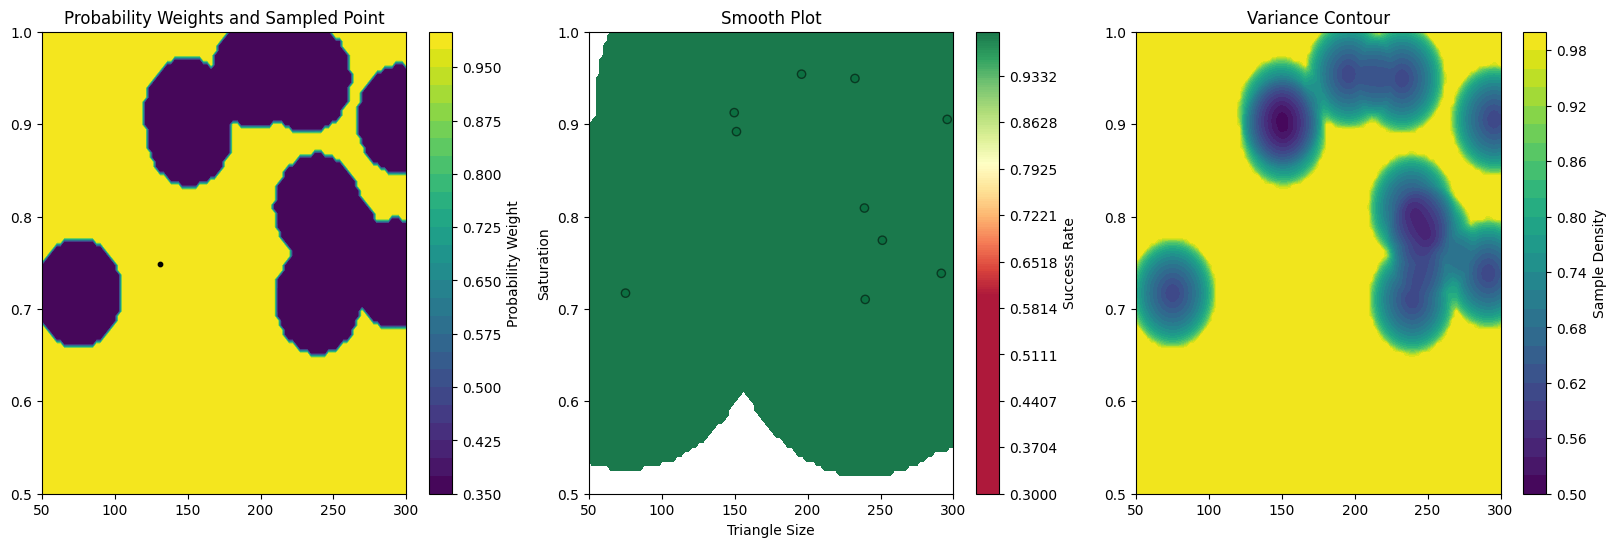

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def sample_point_from_grid(mean_grid, var_grid, 
                           x_bounds=(0, 1), y_bounds=(0, 1),
                           target=0.75,
                           target_method='exponential',  # Default updated to "exponential"
                           variance_influence=1.0, 
                           alpha=1.0):
    """
    Samples a continuous (x,y) point from a grid defined by mean_grid and var_grid.
    The sampling weight for each grid cell is determined solely by a target factor that
    favors cells whose mean is near the specified target value.
    
    Here the base weight is assumed to be uniform (i.e. the integrated probability is 1 for
    all cells), so the final weight depends only on the target factor.
    
    The target factor is computed as:
      - For target_method 'gaussian':
            exp(- ((|mu - target| * alpha) / (sigma**variance_influence))**2)
      - For target_method 'exponential':
            exp(- (|mu - target| * alpha) / (sigma**variance_influence))
    
    Parameters:
      mean_grid : 2D np.array
          Grid of mean values.
      var_grid : 2D np.array
          Grid of variance values.
      x_bounds : tuple (x_min, x_max)
          The continuous domain bounds in x.
      y_bounds : tuple (y_min, y_max)
          The continuous domain bounds in y.
      target : float
          The desired target value (e.g., 0.75).
      target_method : str
          Method to compute the target factor. Options:
            - 'gaussian': uses exp(- ((|mu - target| * alpha) / (sigma**variance_influence))**2)
            - 'exponential': uses exp(- (|mu - target| * alpha) / (sigma**variance_influence))
      variance_influence : float
          The exponent on sigma in the target factor. Higher values increase the influence of variance.
      alpha : float
          A scaling factor applied to |mu - target|.
    
    Returns:
      sample_pt : tuple
          The sampled continuous (x, y) point.
      weights : 2D np.array
          The computed probability weights for each grid cell (before sampling).
    """
    n_rows, n_cols = mean_grid.shape
    # Compute standard deviation; add a tiny value to avoid division by zero.
    std_grid = np.sqrt(var_grid + 1e-12)
    # replace all nan values in mean_grid with target 
    mean_grid = np.nan_to_num(mean_grid, nan=target)
    
    # Use a uniform base weight (i.e., integrated probability = 1 for all cells).
    base_weights = np.ones_like(mean_grid)
    
    # Compute the target factor.
    if target_method == 'gaussian':
        target_factor = np.exp(- ((np.abs(mean_grid - target) * alpha) / (std_grid**variance_influence))**2)
    elif target_method == 'exponential':
        target_factor = np.exp(- (np.abs(mean_grid - target) * alpha) / (std_grid**variance_influence))
    else:
        target_factor = 1.0  # No additional bias.
    
    # The final weight is the product of the base weight and the target factor.
    weights = base_weights * target_factor
    
    # Normalize weights for sampling.
    flat_weights = weights.flatten()
    total_weight = flat_weights.sum()
    if total_weight == 0:
        raise ValueError("All grid cells have zero weight. Check your parameters.")
    flat_weights = flat_weights / total_weight
    
    # Sample one grid cell based on the normalized weights.
    idx = np.random.choice(n_rows * n_cols, p=flat_weights)
    i = idx // n_cols  # row index
    j = idx % n_cols   # column index
    
    # Compute continuous cell boundaries.
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    cell_width = (x_max - x_min) / n_cols
    cell_height = (y_max - y_min) / n_rows
    cell_x_min = x_min + j * cell_width
    cell_y_min = y_min + i * cell_height
    
    # Sample uniformly within the chosen cell.
    x_sample = cell_x_min + np.random.rand() * cell_width
    y_sample = cell_y_min + np.random.rand() * cell_height
    sample_pt = (x_sample, y_sample)
    
    return sample_pt, weights

# --- Sample usage and plotting ---

# Assume you already have your grid arrays (mean, variance) and domain arrays (X, Y).
# For example:
#   mean, variance, triangle_size_bounds, saturation_bounds, X, Y
# are defined in your workspace.

# Use your preferred parameters:
sample_pt, weights = sample_point_from_grid(
    mean, variance,
    x_bounds=triangle_size_bounds, 
    y_bounds=saturation_bounds,
    target=0.75,
    target_method="exponential", 
    variance_influence=0.1, 
    alpha=4.0
)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot a filled contour of the computed probability weights.
contour = axs[0].contourf(X, Y, weights, levels=30, cmap='viridis')
plt.colorbar(contour, ax=axs[0], label="Probability Weight")
# Overlay the sampled point.
axs[0].scatter(sample_pt[0], sample_pt[1], color='black', s=10, label="Sampled Point")
axs[0].set_title("Probability Weights and Sampled Point")

# Create a smooth plot (using your custom plotting function).
from plotting import create_single_smooth_plot
create_single_smooth_plot(
    combinations, triangle_size_bounds, saturation_bounds, ax=axs[1], smoothing_params=smoothing_params
)
axs[1].set_title("Smooth Plot")

# Plot a contour of the variance.
conturf = axs[2].contourf(X, Y, variance, levels=30, cmap='viridis')
plt.colorbar(conturf, ax=axs[2], label='Sample Density')
axs[2].set_title("Variance Contour")

plt.show()

In [21]:
weights

array([[0.88304761, 0.88392972, 0.88486969, ..., 0.90336381, 0.9041279 ,
        0.90563291],
       [0.88296076, 0.88391533, 0.88473039, ..., 0.90376745, 0.90442939,
        0.90607937],
       [0.88300018, 0.88383   , 0.88452689, ..., 0.90402676, 0.90495466,
        0.90617224],
       ...,
       [0.94074113, 0.94064621, 0.94011211, ..., 0.81973052, 0.81927681,
        0.81877265],
       [0.93845389, 0.93856636, 0.93826996, ..., 0.82226161, 0.82171142,
        0.82110315],
       [0.93559814, 0.9358687 , 0.93589312, ..., 0.82478626, 0.82414026,
        0.82349777]], shape=(100, 100))